In [1]:
# Pip install if needed 
# pip install openmeteo-requests

In [2]:
# pip install if needed
# pip install requests-cache retry-requests numpy pandas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler



In [4]:
weather = pd.read_csv('./data/new-york-weather.csv',header = None)
weather.columns = ['date',"daylight_duration","sunshine_duration","rain_sum","showers_sum",
                   "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]
weather.shape

C:\Users\graha\AppData\Local\Temp\ipykernel_12952\3871736691.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv('./data/new-york-weather.csv',header = None)


(288110, 11)

In [5]:
weather = weather.drop(columns = 'showers_sum')

### Drop strings in the dataframe that came from improper appending

In [6]:
weather[weather['daylight_duration'].astype(str).str.contains('day')]

,date,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
260028,date,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
274669,date,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude


In [7]:
weather = weather.drop(weather[weather['daylight_duration'].astype(str).str.contains('day')].index)

In [8]:
weather[weather['daylight_duration'].astype(str).str.contains('day')]

,date,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude


### Sort the dataframe by date

In [9]:
weather = weather.sort_values('date')

### Delete the time in all the dates and remove the white space made

In [10]:
weather['date'] = weather['date'].str.replace('05:00:00+00:00', '')
weather['date'] = weather['date'].str.strip()

In [12]:
weather[["daylight_duration","sunshine_duration","rain_sum",
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]] = weather[["daylight_duration","sunshine_duration","rain_sum",
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]].apply(pd.to_numeric)

In [13]:
weather['precipitation_total'] = weather['rain_sum'] + weather['snowfall_sum'] 
weather['location'] = list(zip(weather['latitude'],weather['longitude']))

,date,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude,precipitation_total,location
265153,2000-01-01,33221.848,28955.312,0.0,0.0,0.0,12.879752,33.480000,41.49,-73.76,0.0,"(41.49, -73.76)"
90552,2000-01-01,33614.598,29877.965,0.0,0.0,0.0,10.739833,25.560000,40.49,-78.76,0.0,"(40.49, -78.76)"
264055,2000-01-01,33221.848,29172.137,0.0,0.0,0.0,12.727922,34.200000,41.49,-76.76,0.0,"(41.49, -76.76)"
189900,2000-01-01,32841.730,28530.727,0.0,0.0,0.0,16.119800,39.239998,42.49,-77.76,0.0,"(42.49, -77.76)"
201588,2000-01-01,32841.730,28672.588,0.0,0.0,0.0,15.003839,36.000000,42.49,-75.76,0.0,"(42.49, -75.76)"


In [20]:
# Group by 'location'
grouped = weather.groupby('location')

# Drop duplicates based on 'date' for each group
weather = pd.concat([group.drop_duplicates(subset=['date']) for _, group in grouped], ignore_index=True)

# Display the first few rows of the cleaned DataFrame
weather.shape

(268392, 12)

In [21]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268392 entries, 0 to 268391
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 268392 non-null  object 
 1   daylight_duration    268392 non-null  float64
 2   sunshine_duration    268392 non-null  float64
 3   rain_sum             268392 non-null  float64
 4   snowfall_sum         268392 non-null  float64
 5   precipitation_hours  268392 non-null  float64
 6   wind_speed_10m_max   268392 non-null  float64
 7   wind_gusts_10m_max   268392 non-null  float64
 8   latitude             268392 non-null  float64
 9   longitude            268392 non-null  float64
 10  precipitation_total  268392 non-null  float64
 11  location             268392 non-null  object 
dtypes: float64(10), object(2)
memory usage: 24.6+ MB


In [22]:
weather.isnull().sum()

date                   0
daylight_duration      0
sunshine_duration      0
rain_sum               0
snowfall_sum           0
precipitation_hours    0
wind_speed_10m_max     0
wind_gusts_10m_max     0
latitude               0
longitude              0
precipitation_total    0
location               0
dtype: int64

Make a clustering model with everything 

In [23]:
weather_km = weather.copy()
X = weather_km.drop(columns = ['date','location','rain_sum','snowfall_sum'])
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Instatiate and fit KMeans
km = KMeans(n_clusters = 5,
           random_state=42)
km.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [24]:
weather_km['cluster'] = km.labels_
centroids = sc.inverse_transform(km.cluster_centers_)
centroids

array([[ 3.68996193e+04,  2.21758616e+04,  2.22931279e+00,
         1.55865401e+01,  3.57611209e+01,  4.17792906e+01,
        -7.64768801e+01,  7.60286752e-01],
       [ 4.93038266e+04,  4.03022327e+04,  1.72032627e+00,
         1.58273625e+01,  3.62288591e+01,  4.13726036e+01,
        -7.43149398e+01,  9.76836938e-01],
       [ 3.94314679e+04,  2.50560439e+04,  4.98536269e+00,
         3.05276981e+01,  6.15651036e+01,  4.20378296e+01,
        -7.66353786e+01,  2.38221820e+00],
       [ 4.38180957e+04,  8.16019500e+03,  1.54191977e+01,
         2.04342274e+01,  4.80443575e+01,  4.19029486e+01,
        -7.64818578e+01,  1.51504220e+01],
       [ 5.03133299e+04,  4.13361955e+04,  2.22206601e+00,
         1.51822143e+01,  3.42940482e+01,  4.23133344e+01,
        -7.80604737e+01,  1.19262393e+00]])

In [25]:
centroids = pd.DataFrame(
    centroids,
    columns=X.columns
)
centroids

,daylight_duration,sunshine_duration,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude,precipitation_total
0,36899.619331,22175.861599,2.229313,15.586540,35.761121,41.779291,-76.476880,0.760287
1,49303.826573,40302.232741,1.720326,15.827362,36.228859,41.372604,-74.314940,0.976837
2,39431.467916,25056.043910,4.985363,30.527698,61.565104,42.037830,-76.635379,2.382218
3,43818.095698,8160.194996,15.419198,20.434227,48.044358,41.902949,-76.481858,15.150422
4,50313.329937,41336.195486,2.222066,15.182214,34.294048,42.313334,-78.060474,1.192624


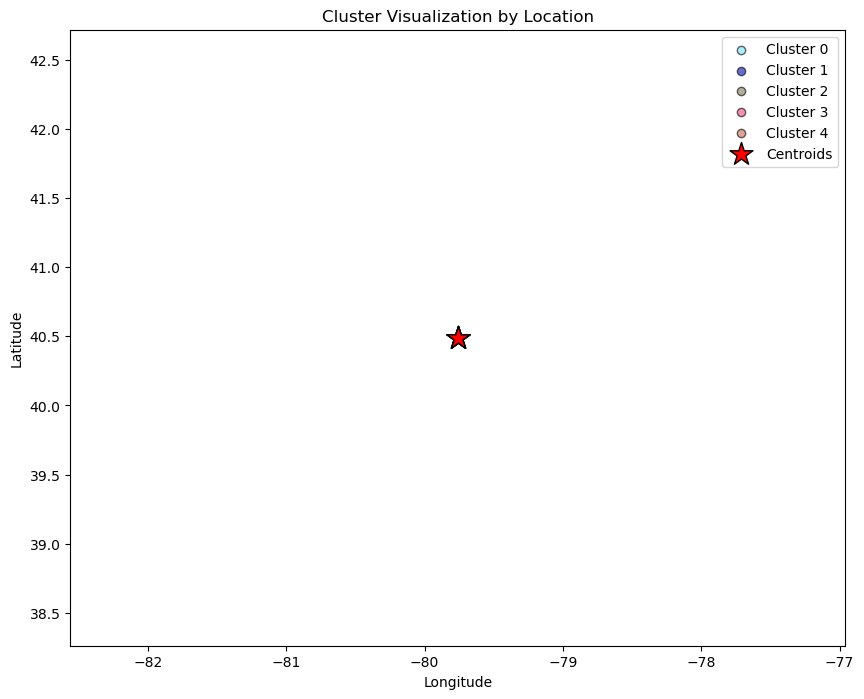

In [20]:
# Generate random RGB colors for clusters
def generate_colors(n_clusters):
    return np.random.rand(n_clusters, 3)


n_clusters = len(np.unique(weather_km['cluster']))
colors = generate_colors(n_clusters)

# Scatterplot for clusters
plt.figure(figsize=(10, 8))
for cluster in np.unique(weather_km['cluster']):
    cluster_data = weather_km[weather_km['cluster'] == cluster]
    plt.scatter(
        cluster_data['longitude'],  # Longitude on x-axis
        cluster_data['latitude'],   # Latitude on y-axis
        c=[colors[cluster]], alpha=0.6, edgecolor="k",
        label=f"Cluster {cluster}"
    )

# Plot centroids
plt.scatter(
    centroids['longitude'], 
    centroids['latitude'],
    c="red", marker="*", s=300, label="Centroids", edgecolor="black"
)

# Add labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Cluster Visualization by Location")
plt.legend()

# Ensure proper aspect ratio for geographic data
plt.axis("equal")
plt.show()

